In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as scp

from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm

In [2]:
column_names = ['user_id', 'film_rating', 'film_id']

In [3]:
row_number = 1 * 10 ** 6
data = pd.read_csv('netflix_data.csv', header=None, names=column_names, nrows=row_number)

In [4]:
data.head()

,user_id,film_rating,film_id
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


## Encoding

In [5]:
from scipy.sparse import hstack
from scipy.sparse import diags

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

In [6]:
encoder = OneHotEncoder(categories="auto")

film_matrix = encoder.fit_transform(np.asarray(data['film_id']).reshape(-1,1))
user_matrix = encoder.fit_transform(np.asarray(data['user_id']).reshape(-1,1))

In [7]:
ones = np.ones(shape=(row_number, 1))
X = hstack([ones, user_matrix, film_matrix]).tocsr()
y = np.asarray(data['film_rating']).reshape(-1,1)

X, y = shuffle(X,y)

## FactorizationMachine 

In [8]:
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2

def RMSE(y_test, y_pred):
    return np.sqrt(MSE(y_test, y_pred))

In [9]:
X.shape, y.shape

((1000000, 283931), (1000000, 1))

In [10]:
class FactorizationMachine:

    def __init__(self,
                 learning_rate=1e-4, epochs=1e4, min_weight_dist=1e-4, factors_num=2,
                 weight=None, factor=None, error=None):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.min_weight_dist = min_weight_dist
        self.factors_num = factors_num
        self.weight = weight
        self.factor = factor
        self.error = error
        

    def predict(self, X, w=None, factor=None):
        if w is None:
            w = self.weight
        if factor is None:
            factor = self.factor

        return X.dot(w) + (np.sum(np.square(X.dot(factor)), axis=1).reshape(-1, 1) - np.sum(X.power(2).dot(np.square(factor)),axis=1).reshape(-1, 1)) / 2

    
    def fit(self, X, y):
        self.weight = np.zeros((X.shape[1], 1))
        self.factor = np.zeros((X.shape[1], self.factors_num))
        self.error = []
        
        w_next = self.weight
        f_next = self.factor

        i = 0
        while (i < self.epochs):
            D_weight = (2 * self.learning_rate / len(y)) * X.T.dot(y - X.dot(self.weight))
            w_next += D_weight

            precomputation = X.dot(self.factor)
            self.weight = w_next
            y_pred = self.predict(X)
            for j in range(f_next.shape[1]):
                a = diags(np.array(precomputation)[:, j]).dot(X)
                b = X.power(2).dot(diags(f_next[:, j]))

                f_next[:, j] += (2 * self.learning_rate / X.shape[1]) * (a - b).T.dot(y - y_pred).reshape((-1,))
            D_factor = f_next - self.factor
            self.factor = f_next
            self.error += [MSE(y, y_pred)]

            i += 1

In [11]:
learning_rate=5e-2
min_weight_dist=1e-4
epochs = 100
n_splits = 5

model_factorization = FactorizationMachine(epochs=epochs, learning_rate=learning_rate, min_weight_dist=min_weight_dist)

model_weight = []
model_factor = []
model_error = []

MSE_train = []
MSE_test  = []
RMSE_train = []
RMSE_test  = []
R2_train  = []
R2_test   = []

kf = KFold(n_splits=n_splits)
kf.get_n_splits(X)
for train_index, test_index in tqdm(kf.split(X)):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    model_factorization.fit(X_train, y_train)
    model_weight += [model_factorization.weight] 
    model_factor += [model_factorization.factor]
    model_error += [model_factorization.error]
    y_train_pred = model_factorization.predict(X_train)
    y_test_pred = model_factorization.predict(X_test)
    
    MSE_train += [MSE(y_train, y_train_pred)]
    MSE_test += [MSE(y_test, y_test_pred)]
    RMSE_train += [RMSE(y_train, y_train_pred)]
    RMSE_test += [RMSE(y_test, y_test_pred)]
    R2_train += [R2(y_train, y_train_pred)]
    R2_test += [R2(y_test, y_test_pred)]

5it [05:34, 66.87s/it]


## Representation

Iteration (1)


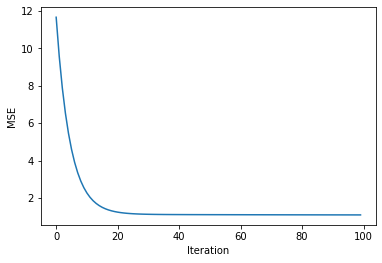

Iteration (2)


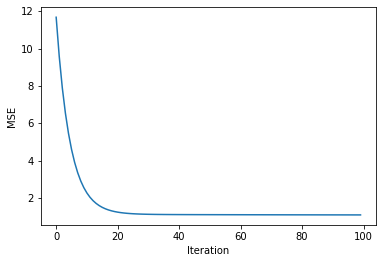

Iteration (3)


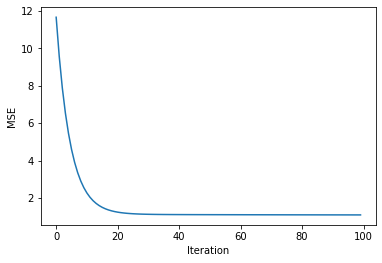

Iteration (4)


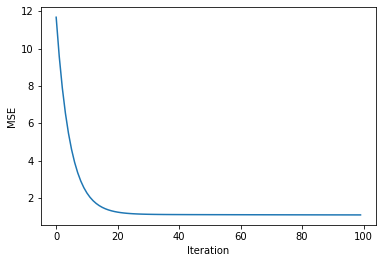

Iteration (5)


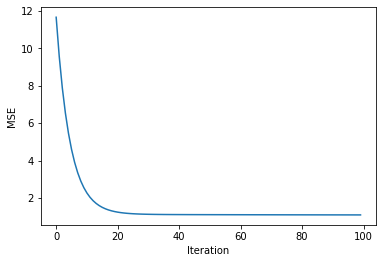

In [18]:
for i, error in enumerate(model_error):
    print(f'Iteration ({i + 1})')
    plt.plot(range(len(error)), error)
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.show()

In [19]:
column_names = []

column_names += ["Names"]
column_names += ["Mean", "Std"]
column_names += [f'Iteration ({i + 1})' for i in range(n_splits)]

In [20]:
row_names = []

row_names += ['MSE Train', 'MSE Test'] 
row_names += ['RMSE Train', 'RMSE Test'] 
row_names += ['R2 Train', 'R2 Test']
row_names += [f'Feature ({i + 1})' for i in range(len(model_weight[0]))]

In [21]:
dataframe = pd.DataFrame(columns=column_names)
dataframe['Names'] = row_names
dataframe.set_index('Names', inplace=True)

In [22]:
for i in range(n_splits):
    dataframe[f'Iteration ({i + 1})'] = np.concatenate(([MSE_train[i], MSE_test[i], RMSE_train[i], RMSE_test[i], R2_train[i], R2_test[i]], model_weight[i].reshape((-1,))))

dataframe['Mean'] = dataframe.mean(axis=1)
dataframe['Std'] = dataframe.std(axis=1)

In [23]:
dataframe

,Mean,Std,Iteration (1),Iteration (2),Iteration (3),Iteration (4),Iteration (5)
Names,,,,,,,
MSE Train,1.095722e+00,7.434349e-04,1.096330e+00,1.096233e+00,1.096405,1.094679,1.094961
MSE Test,1.095775e+00,2.768018e-03,1.093201e+00,1.093735e+00,1.093667,1.099633,1.098638
RMSE Train,1.046767e+00,3.551362e-04,1.047058e+00,1.047011e+00,1.047094,1.046269,1.046404
RMSE Test,1.046792e+00,1.321782e-03,1.045562e+00,1.045818e+00,1.045785,1.048634,1.048159
R2 Train,5.193329e-02,1.563361e-04,5.202818e-02,5.188435e-02,0.051649,0.052082,0.052023
R2 Test,5.188444e-02,3.493571e-04,5.162605e-02,5.207879e-02,0.052481,0.051554,0.051682
Feature (1),3.445964e+00,4.604005e-04,3.445486e+00,3.446233e+00,3.445546,3.446718,3.445838
Feature (2),4.440838e-08,9.046128e-06,8.330982e-08,3.787144e-06,0.000006,-0.000017,0.000008
Feature (3),8.808369e-05,1.934832e-05,1.037415e-04,1.100789e-04,0.000080,0.000091,0.000055
